In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# MIMO Imaging Radar

## Introduction

This notebook demonstrates **high-resolution MIMO (Multiple-Input Multiple-Output) imaging radar**—a sophisticated technology that creates detailed 2D images of targets by exploiting spatial diversity from multiple transmit and receive antennas. MIMO imaging radar is revolutionizing applications from autonomous vehicles to security screening.

### MIMO Radar Fundamentals

**MIMO radar** uses multiple transmitters and receivers to create a **virtual aperture** much larger than the physical antenna array, dramatically improving angular resolution.

**Key Concept:**

A MIMO array with $N_{TX}$ transmitters and $N_{RX}$ receivers creates a **virtual array** with $N_{TX} × N_{RX}$ elements, providing:
- Enhanced angular resolution
- Improved target separation
- Higher degrees of freedom
- Flexible array design

### Virtual Array Synthesis

**Physical vs. Virtual Array:**

- **Physical Array**: Actual antenna elements
- **Virtual Array**: Equivalent array from MIMO processing

**Aperture Size:**

$$D_{virtual} = D_{TX} + D_{RX}$$

Where:
- $D_{virtual}$ = Virtual aperture length
- $D_{TX}$ = Transmit array extent
- $D_{RX}$ = Receive array extent

**Angular Resolution:**

$$\Delta\theta \approx \frac{\lambda}{D_{virtual}}$$

This improved resolution enables radar imaging—resolving closely-spaced targets in angle to form 2D/3D images.

### Imaging Radar Capabilities

**1. High Angular Resolution**
- Sub-degree accuracy from large virtual aperture
- Resolve multiple targets in same range bin
- Create detailed spatial maps

**2. Range-Angle Imaging**
- 2D image: Range × Azimuth (or Elevation)
- 3D image: Range × Azimuth × Elevation
- SAR-like imaging from stationary platform

**3. Multiple Target Handling**
- Separate closely-spaced objects
- Track multiple targets simultaneously
- Clutter suppression through spatial filtering

**4. Flexible Array Design**
- Sparse arrays reduce hardware complexity
- Optimized layouts balance resolution and sidelobes
- Co-prime arrays enhance aperture

### MIMO Advantages

**Compared to Phased Arrays:**

| Feature | Phased Array | MIMO Radar |
|---------|--------------|------------|
| **Aperture** | $N \cdot d$ | $(N_{TX} + N_{RX}) \cdot d$ |
| **Degrees of Freedom** | $N$ | $N_{TX} \times N_{RX}$ |
| **Waveform Diversity** | Single | Multiple orthogonal |
| **Flexibility** | Beam steering | Virtual synthesis |
| **Hardware** | More elements | Fewer elements, more processing |

**Key Benefits:**

1. **Larger Virtual Aperture**: Better resolution with fewer physical elements
2. **Waveform Diversity**: Orthogonal waveforms separate transmitters
3. **Hardware Efficiency**: N_TX + N_RX elements vs. N_TX × N_RX
4. **Parameter Identifiability**: Enhanced target parameter estimation

### Orthogonal Waveforms

**Requirement:**

MIMO radar requires **orthogonal waveforms** to distinguish transmitters at the receiver. Common approaches:

1. **Time Division Multiplexing (TDM)**:
   - Sequential transmission (simplest)
   - Longer frame time

2. **Frequency Division Multiplexing (FDM)**:
   - Different carrier frequencies
   - Wider bandwidth

3. **Code Division Multiplexing (CDM)**:
   - Orthogonal codes (e.g., Gold codes)
   - More complex processing

4. **Doppler Division Multiplexing (DDM)**:
   - Different Doppler shifts
   - Limited to moving targets

**This Example:**

We assume **perfect orthogonality** between transmitters, focusing on imaging processing rather than waveform separation.

### Signal Processing Pipeline

**MIMO Imaging Radar Processing:**

1. **Range FFT**: Extract range profiles
   - Input: Raw baseband [channels, pulses, samples]
   - Output: Range profiles [channels, pulses, range_bins]

2. **CFAR Detection**: Adaptive thresholding
   - Identify range bins containing targets
   - Reduce processing for empty bins

3. **Virtual Array Formation**: Reshape data
   - Map TX/RX to virtual array geometry
   - Apply to detected range bins only

4. **Angular FFT**: 2D FFT for angle estimation
   - Azimuth FFT (horizontal dimension)
   - Elevation FFT (vertical dimension)
   - Output: Range-angle image

5. **Windowing**: Sidelobe suppression
   - Reduce artifacts from FFT processing
   - Chebyshev, Hamming, Taylor windows

### Applications

**Autonomous Vehicles:**
- High-resolution perception for navigation
- Pedestrian and vehicle detection
- Parking assistance and collision avoidance

**Security and Surveillance:**
- Concealed weapon detection
- Perimeter monitoring
- Drone detection and tracking

**Industrial:**
- Robotic vision and manipulation
- Quality inspection
- Level measurement and monitoring

**Medical:**
- Breast cancer detection
- Vital sign monitoring
- Medical imaging

### You'll Learn How To:

- Configure a large MIMO array (64 TX × 128 RX)
- Design virtual array geometry for 2D imaging
- Implement orthogonal transmitter assumption
- Simulate complex multi-target scenes
- Apply range FFT for range compression
- Use 1D CFAR for target range detection
- Reshape data for virtual array processing
- Apply 2D angular FFT for imaging
- Use window functions for sidelobe control
- Generate and interpret 2D radar images

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**System Configuration:**
- 60.5 GHz imaging radar
- 64 transmitters (split into 2 sub-arrays)
- 128 receivers (split into 2 sub-arrays)
- Virtual 1×128 uniform linear array

**Target Scene:**
- Half-ring structure at 20m
- Two 1m diameter spheres
- Complex geometry for imaging demonstration

**Processing:**
- Range FFT with 80 dB Chebyshev window
- OS-CFAR detection (1D)
- 2D angular FFT (1024×1024 points)
- High-resolution image generation

The simulation demonstrates MIMO radar's ability to create detailed 2D images of complex scenes using virtual aperture synthesis.

## MIMO Array Configuration

Design a large virtual aperture using transmit and receive sub-arrays.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for array operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### MIMO Array Design

Configure a sparse MIMO array that synthesizes a large virtual aperture for high-resolution imaging.

**Array Architecture:**

- **Transmitters**: 64 elements (split into 2 sub-arrays of 32 each)
- **Receivers**: 128 elements (split into 2 sub-arrays of 64 each)
- **Virtual Array**: 1×128 uniform linear array in YZ plane
- **Element Spacing**: Optimized for virtual array synthesis

**Design Strategy:**

The transmit and receive arrays are strategically positioned to create a **uniform virtual array** through convolution of TX and RX positions. This sparse physical design creates a dense virtual aperture.

**Virtual Array Formula:**

Virtual element positions = TX positions ⊗ RX positions (convolution)

**Orthogonality Assumption:**

We assume the 2 transmitter groups use **orthogonal waveforms** that can be perfectly separated at the receiver. This could be achieved through:
- Time division (sequential transmission)
- Frequency division (different frequencies)
- Code division (orthogonal codes)

**Angular Resolution:**

With λ/2 virtual spacing and 128 elements:
- Aperture: D = 128 × λ/2 = 64λ
- Angular resolution: Δθ ≈ λ/D ≈ 0.9° (at 60.5 GHz)

In [3]:
# Calculate wavelength for 60.5 GHz
wavelength = 3e8 / 60.5e9  # λ ≈ 4.96 mm

# Define array dimensions
N_tx = 64   # Total transmitters (2 groups of 32)
N_rx = 128  # Total receivers (2 groups of 64)

# Initialize transmitter channel list
tx_channels = []

# First transmitter sub-array (32 elements)
# Positioned along z-axis, offset in y
for idx in range(0, int(N_tx / 2)):
    tx_channels.append(
        dict(
            location=(
                0,  # x-position: at origin
                -N_rx / 2 * wavelength / 4,  # y-position: offset for virtual array
                wavelength * idx - (N_tx / 2 - 1) * wavelength / 2,  # z-position: vertical
            ),
        )
    )

# Second transmitter sub-array (32 elements)
# Positioned along z-axis, different y offset
for idx in range(0, int(N_tx / 2)):
    tx_channels.append(
        dict(
            location=(
                0,  # x-position: at origin
                wavelength * N_rx / 4 - N_rx / 2 * wavelength / 4,  # y-position: different offset
                wavelength * idx - (N_tx / 2 - 1) * wavelength / 2,  # z-position: vertical
            ),
        )
    )

# Initialize receiver channel list
rx_channels = []

# First receiver sub-array (64 elements)
# Positioned along y-axis (horizontal), at bottom z-position
for idx in range(0, int(N_rx / 2)):
    rx_channels.append(
        dict(
            location=(
                0,  # x-position: at origin
                wavelength / 2 * idx - (N_rx / 2 - 1) * wavelength / 4,  # y-position: horizontal
                -(N_tx / 2) * wavelength / 2,  # z-position: bottom
            ),
        )
    )

# Second receiver sub-array (64 elements)
# Positioned along y-axis (horizontal), at top z-position
for idx in range(0, int(N_rx / 2)):
    rx_channels.append(
        dict(
            location=(
                0,  # x-position: at origin
                wavelength / 2 * idx - (N_rx / 2 - 1) * wavelength / 4,  # y-position: horizontal
                wavelength * (N_tx / 2) - (N_tx / 2) * wavelength / 2,  # z-position: top
            ),
        )
    )

### Create Radar System

Configure FMCW radar with MIMO array for imaging.

**Transmitter Configuration:**

- **Frequency**: 61-60 GHz (1 GHz bandwidth sweep)
  - Center: 60.5 GHz (V-band, millimeter wave)
  - Bandwidth: 1 GHz
  - Range resolution: ΔR = c/(2B) = 0.15 m (15 cm)

- **Chirp Duration**: 16 μs
- **Transmit Power**: 15 dBm per channel
- **PRP**: 40 μs
- **Pulses**: 1 (single chirp for imaging)

**Receiver Configuration:**

- **Sampling Rate**: 20 MHz
  - Max range: ~240 m
- **Noise Figure**: 8 dB
- **Gains**: 20 dB RF + 30 dB baseband = 50 dB total

In [4]:
# Configure FMCW transmitter
tx = Transmitter(
    f=[61e9, 60e9],    # Frequency sweep: 61-60 GHz (1 GHz bandwidth, down-chirp)
    t=[0, 16e-6],      # Chirp duration: 0-16 μs
    tx_power=15,       # Transmit power: 15 dBm per channel
    prp=40e-6,         # Pulse repetition period: 40 μs
    pulses=1,          # Single chirp (imaging snapshot)
    channels=tx_channels  # MIMO transmit array
)

# Configure receiver
rx = Receiver(
    fs=20e6,           # Sampling rate: 20 MHz
    noise_figure=8,    # Noise figure: 8 dB
    rf_gain=20,        # RF gain: 20 dB
    load_resistor=500, # Load resistance: 500 Ω
    baseband_gain=30,  # Baseband gain: 30 dB
    channels=rx_channels,  # MIMO receive array
)

# Create complete MIMO imaging radar system
radar = Radar(transmitter=tx, receiver=rx)

### Visualize Array Layout

Display the physical transmit and receive antenna positions to understand the sparse MIMO configuration.

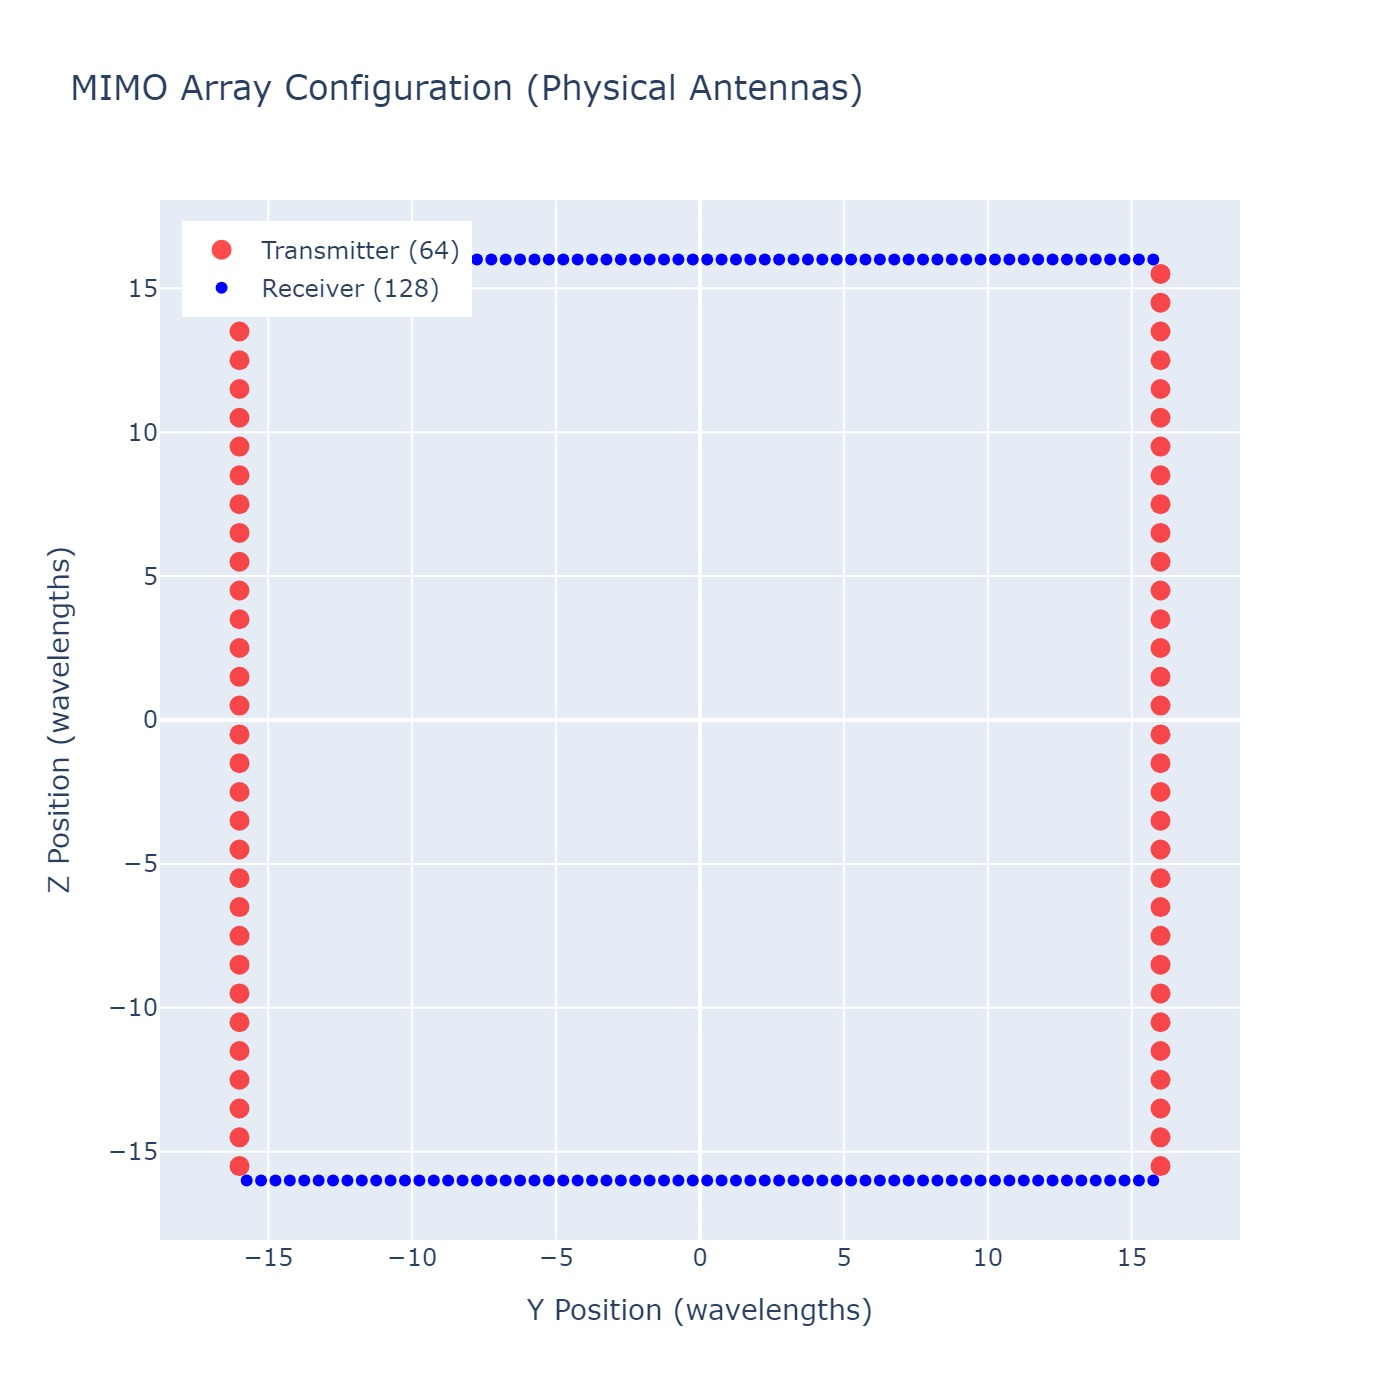

In [5]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Create figure for array visualization
fig = go.Figure()

# Plot transmitter positions (normalized by wavelength)
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 1] / wavelength,
        y=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 2] / wavelength,
        mode="markers",
        name="Transmitter (64)",
        opacity=0.7,
        marker=dict(size=10, color='red'),
    )
)

# Plot receiver positions (normalized by wavelength)
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 1] / wavelength,
        y=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 2] / wavelength,
        mode="markers",
        opacity=1,
        name="Receiver (128)",
        marker=dict(size=6, color='blue'),
    )
)

# Configure plot layout
fig.update_layout(
    title="MIMO Array Configuration (Physical Antennas)",
    height=700,
    xaxis=dict(title="Y Position (wavelengths)"),
    yaxis=dict(title="Z Position (wavelengths)", scaleanchor="x", scaleratio=1),
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Target Scene Configuration

Define a multi-target scene for imaging demonstration.

### Target Models

**Three targets at 20m range:**

1. **Half-Ring Structure**:
   - Complex curved geometry
   - Tests imaging of extended targets
   - Provides spatial structure

2. **Sphere 1** (1m diameter):
   - Located at (20, -1, -1) m
   - Simple canonical shape
   - Known RCS for validation

3. **Sphere 2** (1m diameter):
   - Located at (20, 1, -1) m
   - Separated by 2m in cross-range
   - Tests angular resolution

**Angular Separation:**

At 20m range, 2m separation corresponds to:
- Angle: θ = arctan(2/20) ≈ 5.7°
- Well above system resolution (~0.9°)
- Should be clearly resolved in image

In [6]:
# Target 1: Half-ring structure (extended target)
target_1 = {
    "model": "../models/half_ring.stl",  # Complex curved geometry
    "unit": "m",                          # Model units in meters
    "location": (20, 0, 0),              # Position: 20m range, centered
    "speed": (0, 0, 0),                  # Stationary target
    "rotation": (0, 0, 0),               # No rotation
}

# Target 2: Sphere at left position
ball_1 = {
    "model": "../models/ball_1m.stl",    # 1m diameter sphere
    "unit": "m",                          # Model units in meters
    "location": (20, -1, -1),            # Position: 20m range, -1m Y, -1m Z
    "speed": (0, 0, 0),                  # Stationary
    "rotation": (0, 0, 0),               # No rotation
}

# Target 3: Sphere at right position
ball_2 = {
    "model": "../models/ball_1m.stl",    # 1m diameter sphere
    "unit": "m",                          # Model units in meters
    "location": (20, 1, -1),             # Position: 20m range, +1m Y, -1m Z
    "speed": (0, 0, 0),                  # Stationary
    "rotation": (0, 0, 0),               # No rotation
}

# Combine targets for simulation
targets = [target_1, ball_1, ball_2]

### Visualize Target Scene

Display the 3D geometry of all targets in the imaging scene.

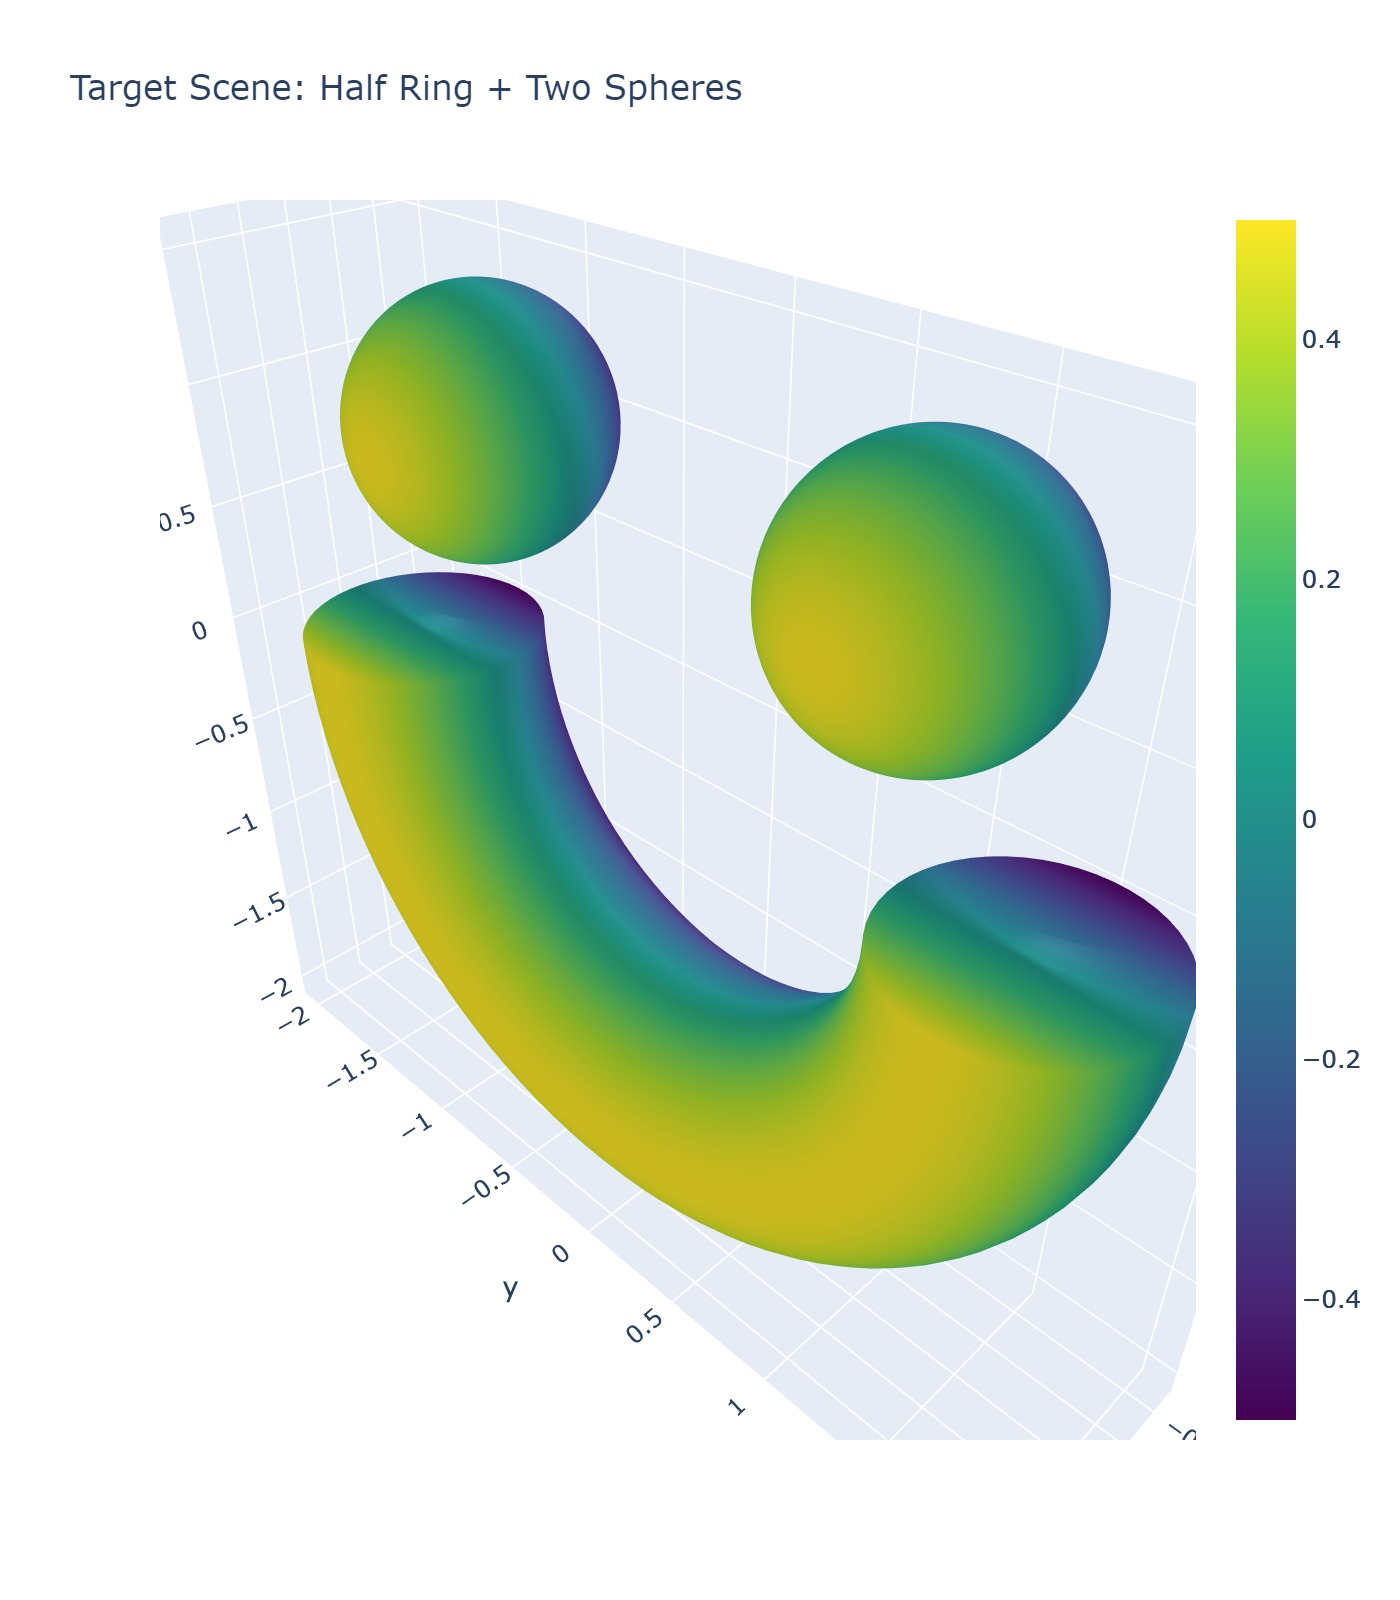

In [7]:
# Import mesh processing library
import pymeshlab

# Create figure for target visualization
fig = go.Figure()

# Load and plot half-ring structure (Target 1)
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=-v_matrix[:, 2],       # Z coordinates (negated for visualization)
        i=f_matrix[:, 0],        # Face indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],  # Color by X position
        colorscale="Viridis",
        name="Half Ring",
    )
)

# Load and plot first sphere (Target 2)
ms = pymeshlab.MeshSet()
ms.load_new_mesh(ball_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1] - 1,    # Y coordinates (offset to -1m)
        z=-v_matrix[:, 2] + 1,   # Z coordinates (offset to -1m, negated)
        i=f_matrix[:, 0],        # Face indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],  # Color by X position
        colorscale="Viridis",
        name="Sphere 1",
    )
)

# Load and plot second sphere (Target 3)
ms = pymeshlab.MeshSet()
ms.load_new_mesh(ball_2["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1] + 1,    # Y coordinates (offset to +1m)
        z=-v_matrix[:, 2] + 1,   # Z coordinates (offset to -1m, negated)
        i=f_matrix[:, 0],        # Face indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],  # Color by X position
        colorscale="Viridis",
        name="Sphere 2",
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels
fig.update_layout(title="Target Scene: Half Ring + Two Spheres")

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Simulate MIMO radar returns from the multi-target scene using ray tracing.

### Simulation Parameters

**Ray Tracing Configuration:**

- **Density**: 0.3 rays per wavelength²
  - Moderate density balances accuracy and speed
  - Sufficient for imaging resolution
  - Higher than typical due to complex geometry

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
- **Channels**: 64 TX × 128 RX = 8,192 virtual channels
- **Pulses**: 1 (single imaging snapshot)
- **Samples**: 320 per chirp (20 MHz × 16 μs)

**Computational Note:**

With 8,192 channels, this simulation is computationally intensive:
- Large data matrix (8,192 × 1 × 320)
- Complex ray tracing for multiple targets
- Expected runtime: 1-5 minutes depending on hardware

In [8]:
# Import radar simulator and timing module
from radarsimpy.simulator import sim_radar
import time

# Start timing
tic = time.time()

# Simulate MIMO radar returns from multi-target scene
# density=0.3: Ray tracing density for complex geometry
data = sim_radar(radar, targets, density=0.3)

# Extract baseband I/Q signals and add system noise
baseband = data["baseband"] + data["noise"]  # Complex samples [8192, 1, 320]

# End timing
toc = time.time()

# Display execution time
print("Exec time:", toc - tic, "s")

Exec time: 341.0247759819031 s


## Radar Signal Processing

Process MIMO data to generate high-resolution 2D image.

### Step 1: Range Processing and Detection

**Range FFT:**

Apply FFT across fast-time to compress chirp into range bins:
- Input: Baseband [8192 channels, 1 pulse, 320 samples]
- Window: Chebyshev with 80 dB sidelobe suppression
- Output: Range profiles [8192, 1, 320 range bins]

**CFAR Detection:**

Apply 1D OS-CFAR to averaged range profile to identify target ranges:
- Average across all channels to improve SNR
- OS-CFAR parameters optimized for imaging scenario
- Output: Threshold for each range bin

In [9]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create Chebyshev window for range FFT (80 dB sidelobe suppression)
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=80)

# Perform range FFT to compress chirp
# Input: baseband [8192 channels, 1 pulse, 320 samples]
# Output: range_profile [8192 channels, 1 pulse, 320 range_bins]
range_profile = proc.range_fft(baseband, rwin=range_window)

# Average range profile across all channels for detection
# Improves SNR by coherent averaging
range_profile_avg = np.mean(np.abs(range_profile[:, :, :]), axis=0)

# Apply 1D OS-CFAR for target range detection
cfar = proc.cfar_os_1d(
    range_profile_avg[0, :],  # Input: Averaged range profile
    guard=0,                   # Guard cells: 0 (fine resolution)
    trailing=10,               # Trailing cells: 10 (reference window)
    k=14,                      # Ordered statistic rank
    pfa=1e-4,                  # Probability of false alarm
    offset=1.1,                # Additional threshold margin
    detector="linear",         # Linear power detection
)

### Visualize Range Profile and Detection Threshold

Display averaged range profile with CFAR threshold to identify target range bins.

**Expected Features:**

- **Peak at 20m**: All three targets at same range
- **CFAR Threshold**: Adaptive threshold adapts to noise floor
- **Detection**: Profile exceeds threshold at target range

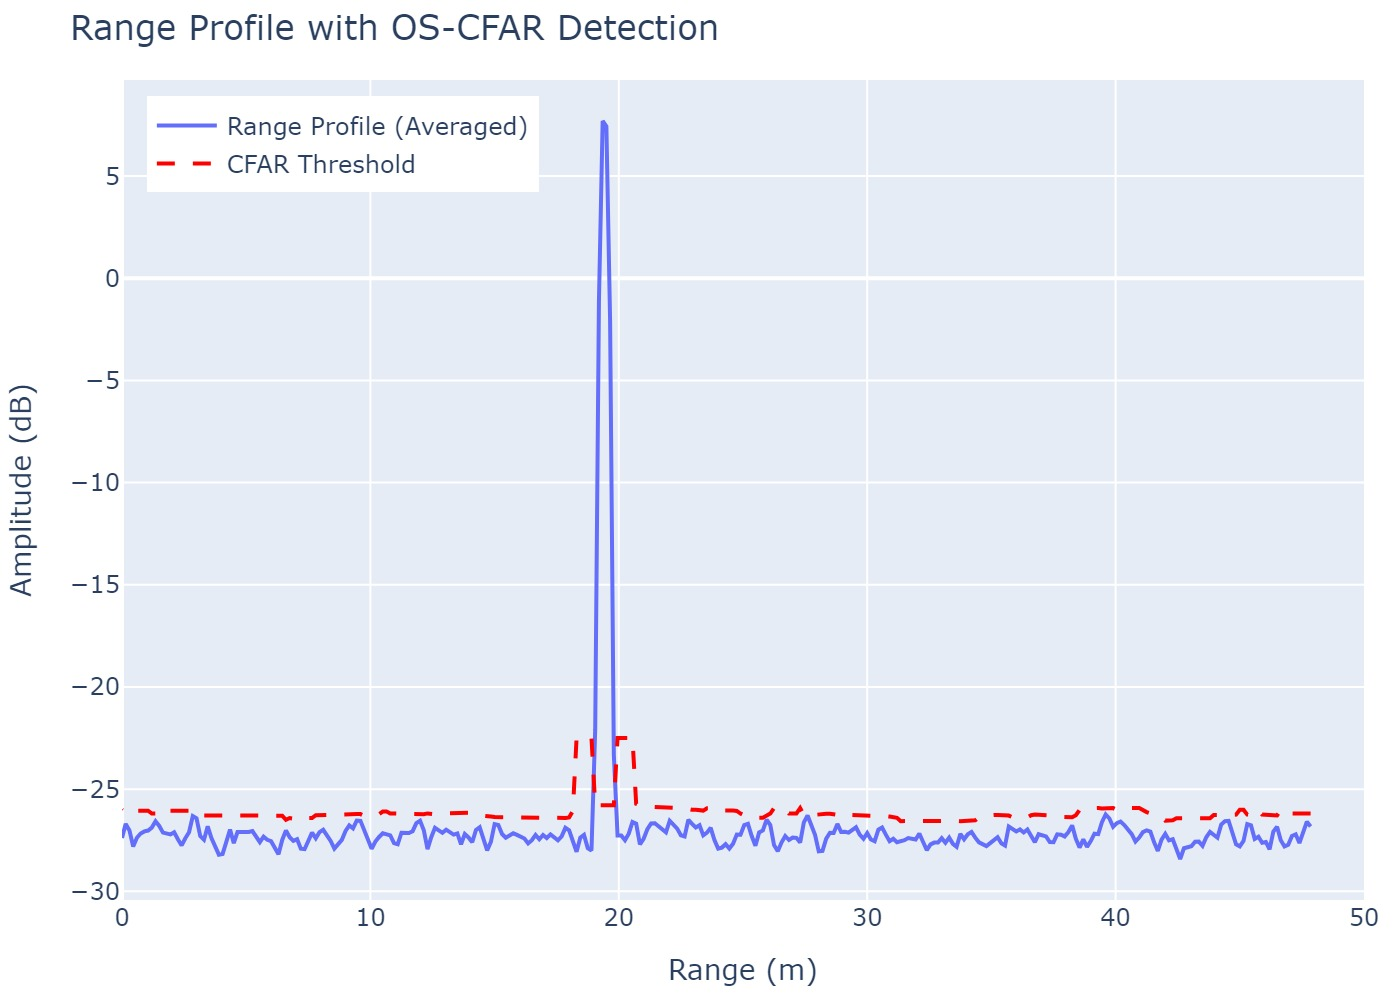

In [10]:
# Calculate maximum unambiguous range
max_range = (
    3e8  # Speed of light
    * radar.radar_prop["receiver"].bb_prop["fs"]  # Sampling rate
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]  # Chirp duration
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]  # Chirp bandwidth
    / 2  # Two-way propagation
)

# Create range axis (flipped because down-chirp)
range_axis = np.flip(
    np.linspace(0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False)
)

# Create figure for range profile
fig = go.Figure()

# Plot averaged range profile
fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(range_profile_avg[0, :]),  # Convert to dB
        name="Range Profile (Averaged)",
        line=dict(width=2),
    )
)

# Plot CFAR threshold
fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(cfar),  # Convert to dB
        name="CFAR Threshold",
        line=dict(width=2, dash='dash', color='red'),
    )
)

# Configure plot layout
fig.update_layout(
    title="Range Profile with OS-CFAR Detection",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)", range=[0, 50]),  # Focus on target range
    height=500,
    legend=dict(x=0.02, y=0.98),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Step 2: Angular Processing for Imaging

**Virtual Array Formation:**

Reshape the MIMO data into virtual array geometry:
- Map 8,192 channels to 64×128 virtual array
- Process only range bins with detections (efficiency)

**2D Angular FFT:**

Apply 2D FFT for azimuth and elevation imaging:
1. **Window Application**: Chebyshev windows in both dimensions (50 dB)
2. **2D FFT**: 1024×1024 point FFT for high angular resolution
3. **Maximum Projection**: Combine multiple range bins

**Processing Strategy:**

For each detected range bin:
1. Extract MIMO data [8,192 channels]
2. Reshape to virtual array [64 TX × 128 RX]
3. Apply 2D window [64×128]
4. Zero-pad and compute 2D FFT [1024×1024]
5. Shift zero frequency to center
6. Take maximum across all range bins

**Angular Resolution:**

With 1024-point FFT and 128-element aperture:
- Angular bins: 1024
- Field of view: ≈ ±45° (depending on array design)
- Resolution: ~0.09° per bin

In [11]:
# Import FFT functions
from scipy import fft
from scipy import signal

# Create 1D windows for angular FFT (50 dB sidelobe suppression)
win_el = signal.windows.chebwin(64, at=50)   # Elevation window (64 TX elements)
win_az = signal.windows.chebwin(128, at=50)  # Azimuth window (128 RX elements)

# Create 2D window matrix by outer product
# Applies window in both dimensions simultaneously
win_mat = np.tile(win_el[..., np.newaxis], (1, N_rx)) * np.tile(
    win_az[np.newaxis, ...], (N_tx, 1)
)

# Find detected range bins (where signal exceeds CFAR threshold)
det_idx = np.where(range_profile_avg > cfar)[1]

# Initialize 2D image spectrum
spec = np.zeros((1024, 1024))

# Process each detected range bin
for peak_idx in range(0, len(det_idx)):
    # Extract MIMO data for this range bin [8192 channels]
    raw_bv = range_profile[:, 0, det_idx[peak_idx]]

    # Initialize virtual array matrix [64 TX × 128 RX]
    bv = np.zeros((N_tx, N_rx), dtype=np.complex128)

    # Reshape MIMO channels to virtual array geometry
    # Data is organized as: [TX0-RX_all, TX1-RX_all, ..., TX63-RX_all]
    # Split into two TX sub-arrays and two RX sub-arrays
    half_tx = int(N_tx / 2)  # 32
    half_rx = int(N_rx / 2)  # 64
    
    # Map first TX sub-array (32 elements) to virtual array
    for t_idx in range(0, half_tx):
        # First RX sub-array (64 elements)
        bv[t_idx, 0:half_rx] = raw_bv[t_idx * N_rx : (t_idx * N_rx + half_rx)]
        # Second RX sub-array (64 elements)
        bv[t_idx, half_rx:] = raw_bv[
            int((t_idx + half_tx) * N_rx) : ((t_idx + half_tx) * N_rx + half_rx)
        ]

        # Map second TX sub-array (32 elements) to virtual array
        bv[t_idx + half_tx, 0:half_rx] = raw_bv[
            (t_idx * N_rx + half_rx) : (t_idx * N_rx + N_rx)
        ]
        bv[t_idx + half_tx, half_rx:] = raw_bv[
            int((t_idx + half_tx) * N_rx + half_rx) : int(
                (t_idx + half_tx) * N_rx + N_rx
            )
        ]
    
    # Apply 2D window to virtual array
    bv_windowed = bv[:, :] * win_mat
    
    # Compute 2D FFT for angular processing
    # Zero-pad to 1024×1024 for fine angular resolution
    # fftshift centers zero frequency
    angular_spectrum = np.abs(fft.fftshift(fft.fft2(bv_windowed, s=[1024, 1024])))
    
    # Take maximum across all range bins (brightest pixel projection)
    spec = np.maximum(spec, angular_spectrum)

### Visualize MIMO Imaging Result

Display the 2D radar image showing angular distribution of targets.

**Image Interpretation:**

- **Horizontal Axis**: Azimuth angle (Y direction)
- **Vertical Axis**: Elevation angle (Z direction)
- **Brightness**: Target reflectivity (dB scale)

**Expected Features:**

1. **Two Bright Spots**: Two spheres separated horizontally (~2m at 20m range)
2. **Ring Structure**: Half-ring creates extended pattern
3. **Angular Resolution**: Clearly separated targets demonstrate sub-degree resolution
4. **Sidelobes**: Low sidelobes from 50 dB Chebyshev windowing

**Image Quality Factors:**

- Large virtual aperture (128 elements) provides fine angular resolution
- 80 dB range windowing reduces range sidelobes
- 50 dB angular windowing balances resolution and sidelobes
- Maximum projection across range creates composite image

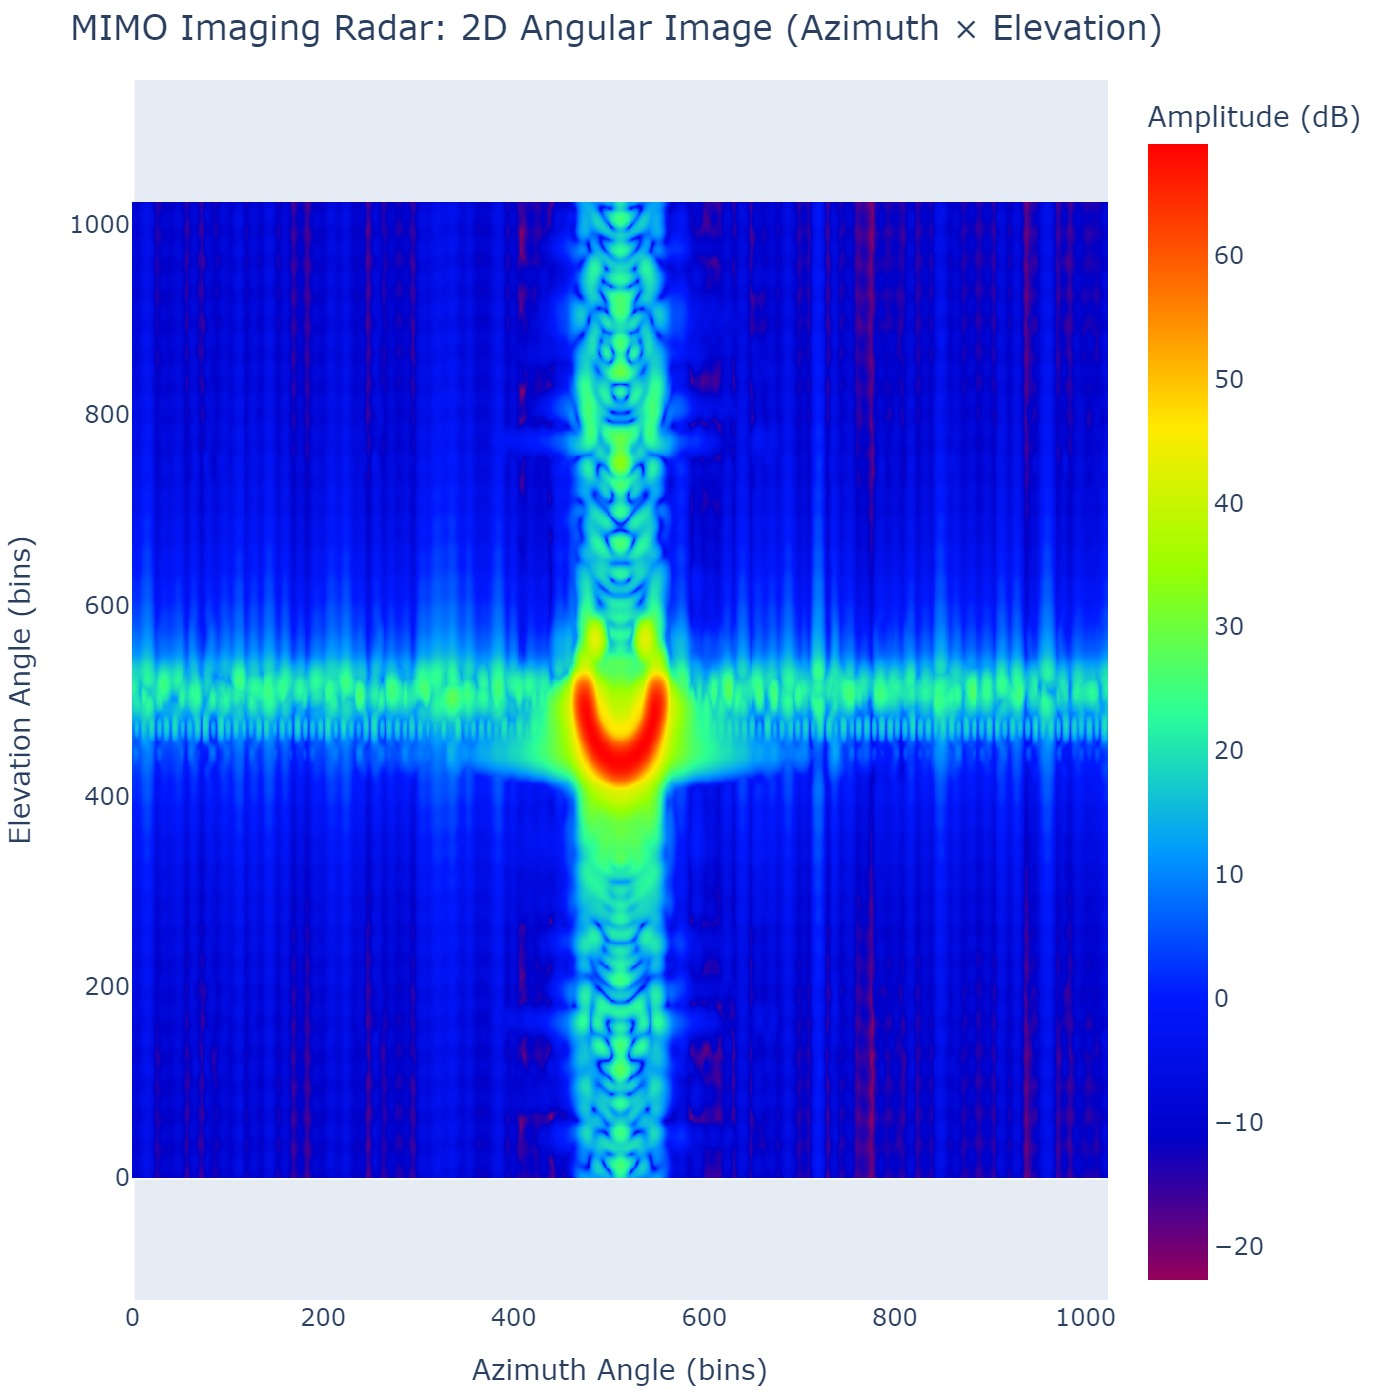

In [12]:
# Create 2D heatmap for radar image
fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        z=20 * np.log10(spec),  # Convert to dB scale
        colorscale="Rainbow",    # Rainbow colormap (blue=low, red=high)
        colorbar=dict(title="Amplitude (dB)"),
        zmin=20 * np.log10(np.max(spec)) - 40,  # Dynamic range: 40 dB
    )
)

# Configure plot layout
fig.update_layout(
    title="MIMO Imaging Radar: 2D Angular Image (Azimuth × Elevation)",
    height=700,
    xaxis=dict(title="Azimuth Angle (bins)", showgrid=False),
    yaxis=dict(
        title="Elevation Angle (bins)",
        scaleanchor="x",
        scaleratio=1,
        showgrid=False
    ),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement high-resolution MIMO imaging radar using RadarSimPy:

### Key Takeaways

**1. MIMO Radar Fundamentals**
- Understood virtual aperture synthesis from multiple TX/RX elements
- Learned how N_TX × N_RX creates large virtual array
- Recognized angular resolution improvement: Δθ ≈ λ/D_virtual
- Appreciated hardware efficiency: fewer elements, better resolution

**2. Array Design and Configuration**
- Designed 64 TX × 128 RX sparse MIMO array
- Created virtual 1×128 uniform linear array
- Optimized element spacing for virtual array synthesis
- Understood sub-array architecture (2 TX groups, 2 RX groups)

**3. Orthogonal Waveform Assumption**
- Assumed perfect orthogonality between transmitters
- Understood separation techniques (TDM, FDM, CDM, DDM)
- Focused on imaging processing rather than waveform details
- Recognized practical implementation considerations

**4. Multi-Target Scene Simulation**
- Modeled complex scene (half-ring + 2 spheres)
- Configured targets at same range, different angles
- Simulated 8,192 virtual channels (64×128)
- Generated realistic radar returns with ray tracing

**5. Range Processing Pipeline**
- Applied range FFT with 80 dB Chebyshev window
- Averaged across channels for improved detection SNR
- Used 1D OS-CFAR for adaptive range detection
- Identified target range bins for imaging processing

**6. Virtual Array Formation**
- Reshaped MIMO data to virtual array geometry [64×128]
- Mapped physical channels to virtual element positions
- Understood data organization and indexing
- Processed only detected range bins for efficiency

**7. 2D Angular FFT Imaging**
- Applied 2D Chebyshev windows (50 dB) in both dimensions
- Computed 1024×1024 FFT for fine angular resolution
- Used fftshift to center zero frequency
- Combined multiple range bins via maximum projection

**8. Image Interpretation**
- Generated 2D angular image (azimuth × elevation)
- Observed separated spheres demonstrating angular resolution
- Identified extended structure from half-ring
- Analyzed sidelobe performance from windowing

### Experiment Further

Try modifying the parameters to explore different scenarios:

**1. Array Configuration Studies**:
- Vary number of TX elements: 32, 128, 256
- Change RX elements: 64, 256, 512
- Test different virtual array layouts
- Compare sparse vs. filled arrays

**2. Angular Resolution Analysis**:
- Calculate theoretical resolution: Δθ = λ/D
- Measure actual resolution from image
- Test Rayleigh criterion with closer targets
- Plot angular point spread function

**3. Window Function Comparison**:
- Test Hamming, Hanning, Blackman windows
- Vary sidelobe levels: 30, 60, 100 dB
- Compare resolution vs. sidelobe trade-offs
- Analyze main lobe width impact

**4. Target Separation Studies**:
- Move spheres closer: 0.5m, 1m separation
- Test angular resolution limits
- Vary range: 10m, 50m, 100m
- Observe resolution degradation with range

**5. FFT Size Optimization**:
- Reduce to 512×512 for faster processing
- Increase to 2048×2048 for finer bins
- Analyze computation time vs. resolution
- Understand zero-padding effects

**6. Multi-Range Imaging**:
- Place targets at different ranges
- Create 3D image (range × azimuth × elevation)
- Implement range-gating for specific depths
- Visualize 3D point clouds

**7. CFAR Parameter Tuning**:
- Adjust guard and trailing cells
- Test different P_fa values
- Compare CA-CFAR vs. OS-CFAR
- Analyze detection probability vs. false alarms

**8. Frequency and Bandwidth**:
- Test different frequencies: 24, 77, 94 GHz
- Vary bandwidth: 500 MHz, 2 GHz, 4 GHz
- Observe range resolution changes
- Understand wavelength effects on array

**9. Complex Scene Imaging**:
- Add more targets at various positions
- Test cluttered environments
- Simulate extended targets (vehicles, buildings)
- Analyze image quality metrics (SNR, contrast)

**10. Advanced Processing**:
- Implement beamforming instead of FFT
- Apply adaptive filtering techniques
- Test super-resolution algorithms (MUSIC, ESPRIT)
- Implement synthetic aperture radar (SAR) processing

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Processing Module: https://radarsimx.github.io/radarsimpy/process.html
- MIMO Radar: Virtual array synthesis and signal processing
- Imaging Radar: 2D/3D target visualization techniques
- Beamforming: Spatial filtering and angular estimation
- SAR Processing: Synthetic aperture radar imaging
- Array Signal Processing: DOA estimation and beamforming
- Automotive Radar: High-resolution imaging for ADAS